# 🎯 Uplift modeling `metrics`

In [1]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift dill catboost

# 📝 Load data

We are going to use a `Lenta dataset` from the BigTarget Hackathon hosted in summer 2020 by Lenta and Microsoft.

Lenta is a russian food retailer. 

### Data description

✏️ Dataset can be loaded from `sklift.datasets` module using `fetch_lenta` function.

Read more about dataset <a href="https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html">in the api docs</a>.  

This is an uplift modeling dataset containing data about Lenta's customers grociery shopping, marketing campaigns communications as `treatment` and store visits as `target`.

####  ✏️ Major columns:

- `group` - treatment / control flag
- `response_att` - binary target
- `CardHolder` - customer id
- `gender` - customer gender 
- `age` - customer age

In [2]:
from sklift.datasets import fetch_lenta

# returns sklearn Bunch object
# with data, target, treatment keys
# data features (pd.DataFrame), target (pd.Series), treatment (pd.Series) values 
dataset = fetch_lenta()

In [3]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (687029, 193)
Dataset target shape: (687029,)
Dataset treatment shape: (687029,)


# 📝 EDA

In [4]:
dataset.data.head().append(dataset.data.tail())

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,1.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,7.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,1.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,2.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495
687024,35.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,0.0,3.0,...,550.09,669.33,111.87,0.00,330.96,1173.84,119.99,2.6458,0.3646,0.3282
687025,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,28.01,0.0000,0.0000,0.0000
687026,36.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.00,0.00,0.00,0.00,0.00,449.01,0.00,0.0000,NaN,NaN
687027,37.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.00,46.72,0.00,0.00,0.00,0.00,0.00,0.0000,NaN,NaN
687028,40.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,...,290.01,0.00,0.00,0.00,228.47,752.32,596.86,0.0000,0.0000,0.0000


### 🤔 target share for `treatment / control` 

In [5]:
import pandas as pd 

pd.crosstab(dataset.treatment, dataset.target, normalize='index')

response_att,0,1
group,,
control,0.897421,0.102579
test,0.889874,0.110126


In [6]:
# make treatment binary
treat_dict = {
    'test': 1,
    'control': 0
}

dataset.treatment = dataset.treatment.map(treat_dict)

In [7]:
# convert NaNs to str 
# in the categorical feature `gender` for CatBoostClassifier
dataset.data['gender'] = dataset.data['gender'].astype(str)

print(dataset.data['gender'].value_counts(dropna=False))

Ж               433448
М               243910
nan               8581
Не определен      1090
Name: gender, dtype: int64


### ✂️ train test split

- stratify by two columns: treatment and target. 

`Intuition:` In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one. 

In [8]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (480920, 193)
Validation shape: (206109, 193)


# 👾 Class Transformation uplift model

`Class transformation` method is described <a href="https://www.uplift-modeling.com/en/latest/user_guide/models/revert_label.html"> here</a>  

Class transormation method `may` be used in case of treatment unbalanced data. In this case one will get not an uplift score but some *ranking* score still useful for ranking objects.

In [10]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

estimator = CatBoostClassifier(verbose=100, 
                               cat_features=[55],
                               random_state=42,
                               thread_count=1)

ct_model = ClassTransformation(estimator=estimator)

In [11]:
ct_model.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)

/Users/macdrive/GoogleDrive/Проекты/Uplift/sklift-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


Learning rate set to 0.143939
0:	learn: 0.6685632	total: 1.02s	remaining: 17m 3s
100:	learn: 0.5948982	total: 1m 26s	remaining: 12m 52s
200:	learn: 0.5907078	total: 3m 5s	remaining: 12m 16s
300:	learn: 0.5869612	total: 4m 37s	remaining: 10m 45s
400:	learn: 0.5834846	total: 6m 11s	remaining: 9m 14s
500:	learn: 0.5800625	total: 7m 47s	remaining: 7m 45s
600:	learn: 0.5768776	total: 9m 20s	remaining: 6m 11s
700:	learn: 0.5737194	total: 10m 53s	remaining: 4m 38s
800:	learn: 0.5706632	total: 12m 27s	remaining: 3m 5s
900:	learn: 0.5677118	total: 14m 7s	remaining: 1m 33s
999:	learn: 0.5648597	total: 15m 36s	remaining: 0us


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x106357780>)

### Save model

In [12]:
import dill

with open("model.dill", 'wb') as f:
    dill.dump(ct_model, f)

### Uplift prediction

In [13]:
uplift_ct = ct_model.predict(X_val)

# 🚀🚀🚀 Uplift metrics

##  🚀 `uplift@k`

- uplift at first k%
- falls between [0; 1] depending on k, model quality and data


#### `uplift@k` = `target mean at k% in the treatment group` - `target mean at k% in the control group`

___

How to count `uplift@k`:

1. sort by predicted uplift
2. select first k%
3. count target mean in the treatment group
4. count target mean in the control group
5. substract the mean in the control group from the mean in the treatment group


In [14]:
from sklift.metrics import uplift_at_k

# k = 10%
k = 0.1  

# strategy='overall' sort by uplift treatment and control together
uplift_overall = uplift_at_k(y_val, uplift_ct, trmnt_val, strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup = uplift_at_k(y_val, uplift_ct, trmnt_val, strategy='by_group', k=k)


print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")

uplift@10%: 0.1467 (sort groups by uplift together)
uplift@10%: 0.1503 (sort groups by uplift separately)


## 🚀 `uplift_by_percentile` table

Count metrics for each percentile in data in descending order by uplift prediction (by rows):

- `n_treatment` - treatment group size in the one percentile
- `n_control` - control group size in the one perentile
- `response_rate_treatment` -  target mean in the treatment group in the one percentile
- `response_rate_control` - target mean in the control group in the one percentile
- `uplift = response_rate_treatment - response_rate_control` in the one percentile

---

Function parameter options are:

- `total=True` - show total metric on full data
- `std=True` - show metrics std by row 

In [15]:
from sklift.metrics import uplift_by_percentile

uplift_by_percentile(y_val, uplift_ct, trmnt_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,12715,7896,0.366339,0.219605,0.146734,0.004273,0.004659,0.006321
10-20,15560,5051,0.214267,0.197783,0.016485,0.003289,0.005605,0.006499
20-30,15683,4928,0.149525,0.130682,0.018843,0.002848,0.004801,0.005582
30-40,15675,4936,0.111388,0.098663,0.012725,0.002513,0.004245,0.004933
40-50,15798,4813,0.082795,0.077914,0.004881,0.002192,0.003864,0.004442
50-60,15776,4835,0.062500,0.057911,0.004589,0.001927,0.003359,0.003873
60-70,15768,4843,0.051560,0.050176,0.001385,0.001761,0.003137,0.003597
70-80,15793,4818,0.042171,0.034869,0.007301,0.001599,0.002643,0.003089
80-90,15884,4727,0.035193,0.031521,0.003672,0.001462,0.002541,0.002932


## 🚀 `weighted average uplift `

- counts uplift on full data
- uses results from `uplift_by_percentile` table
- result depends on number of bins

#### `weighted average uplift` = `sum of uplift by percentile weighted on the treatment group size`


In [16]:
from sklift.metrics import weighted_average_uplift

uplift_full_data = weighted_average_uplift(y_val, uplift_ct, trmnt_val, bins=10) 
print(f"average uplift on full data: {uplift_full_data:.4f}")

average uplift on full data: 0.0189


## 🚀 `uplift_by_percentile` plot

- visualize results of `uplift_by_percentile` table

Two ways to plot:

- line plot `kind='line'`
- bar plot `kind='bar'`


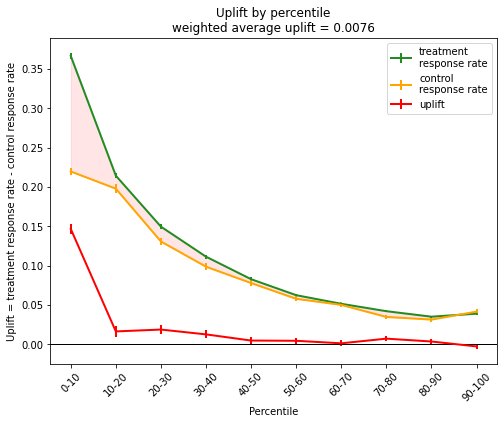

In [17]:
from sklift.viz import plot_uplift_by_percentile

# line plot
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='line');

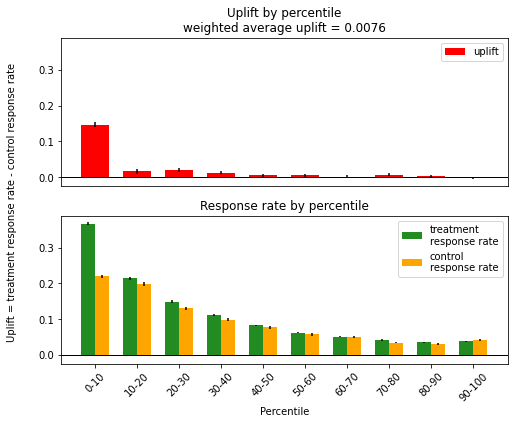

In [18]:
# bar plot
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='bar');

## 🚀  `Qini curve` 

The curve plots the absolute incremental outcome of the treated group compared to group with no treatment. 


plot Qini curve: 
- `blue line` is a `real Qini curve` based on data.
- `red line` is an `ideal Qini curve` based on data. Code: `perfect=True`
- `grey line` is a `random Qini curve` based on data
    

## 🚀 `AUQC` (`area under Qini curve` or `Qini coefficient`)

`Qini coefficient` = `light blue area between the real Qini curve and the random Qini curve normalized on area between the random and the ideal line`


<div>
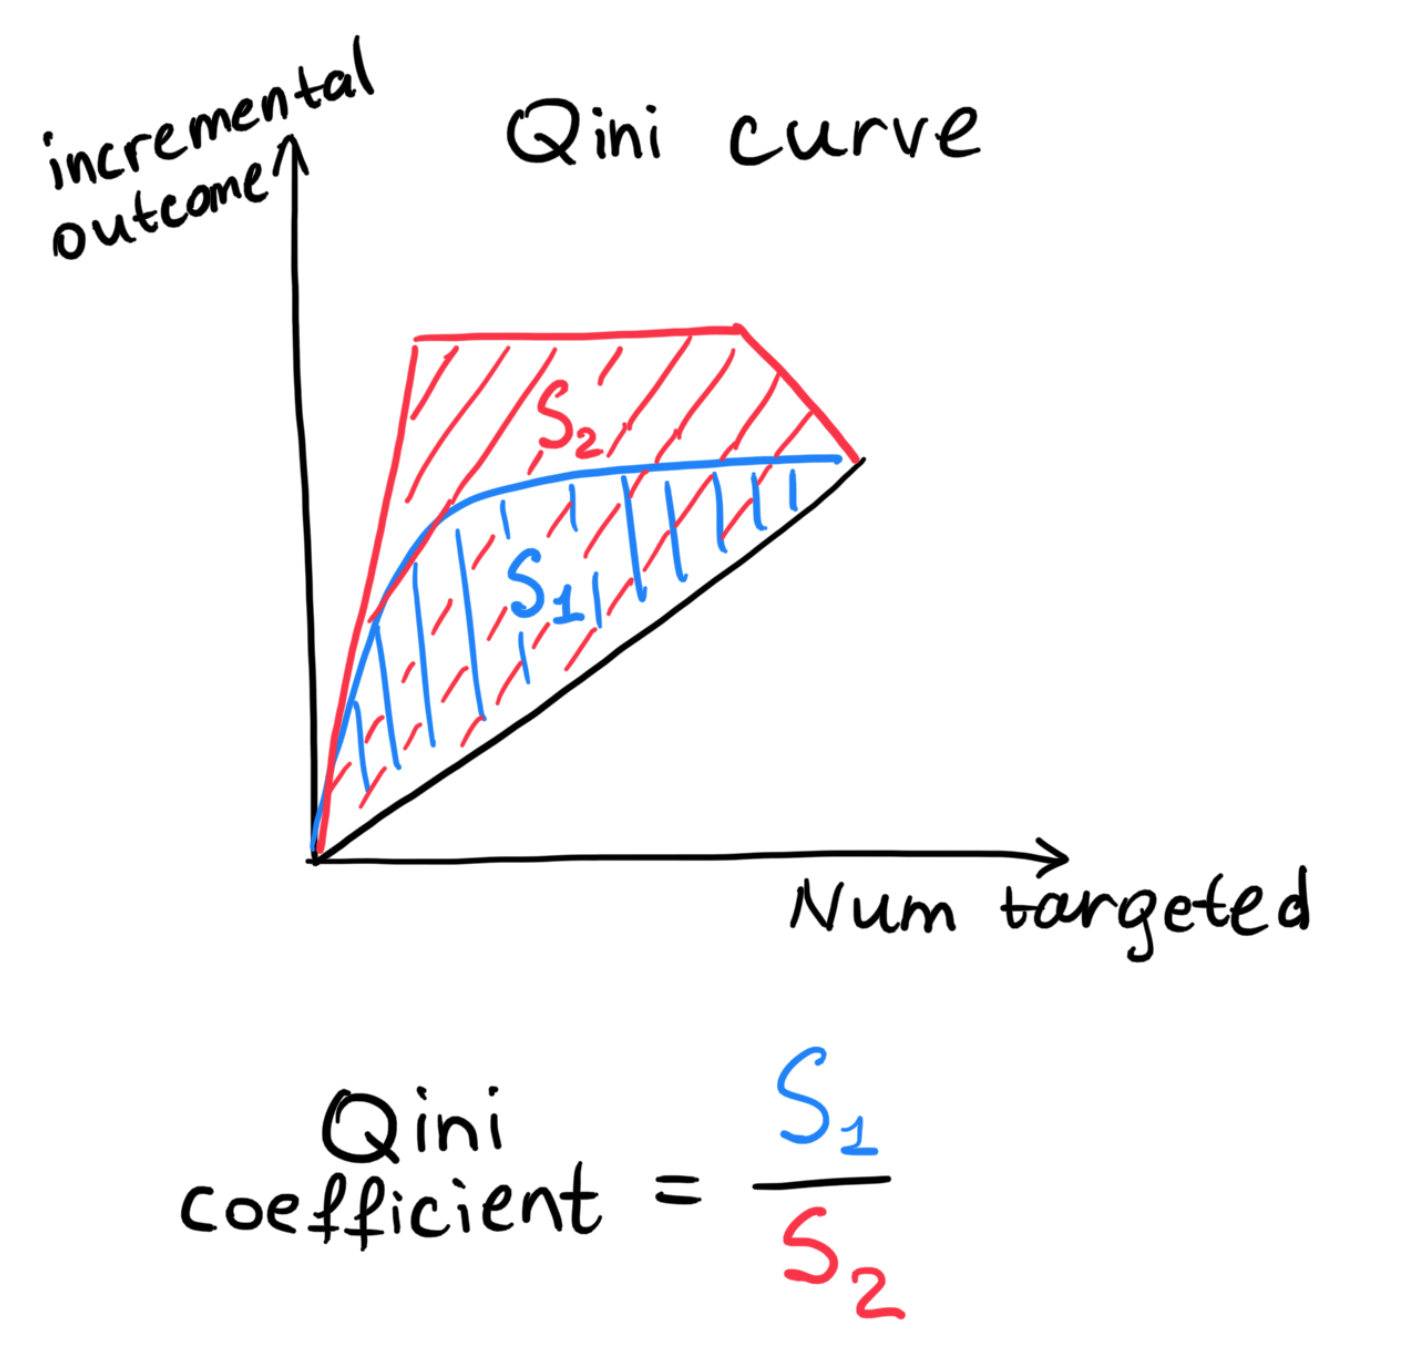
</div>


- metric is printed at the title of the Qini curve plot
- can be called as a separate function

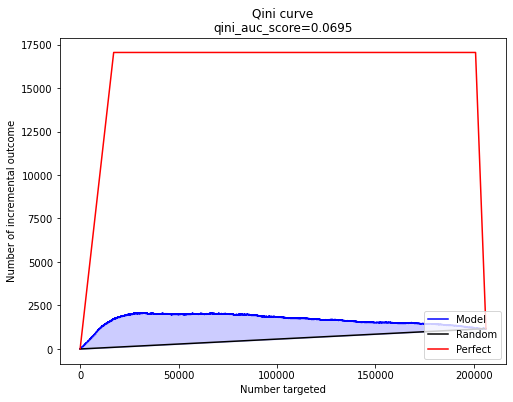

In [19]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_val, uplift_ct, trmnt_val, perfect=True);

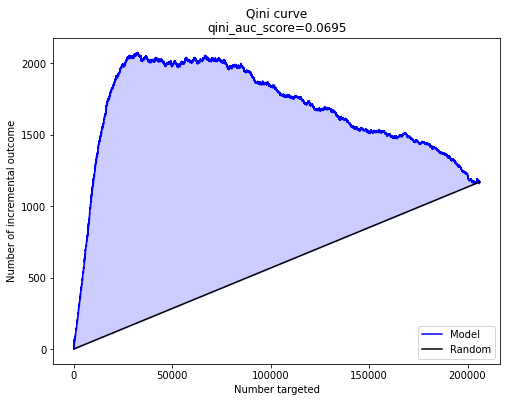

In [20]:
# no ideal Qini curve
# only real Qini curve
# perfect=False
plot_qini_curve(y_val, uplift_ct, trmnt_val, perfect=False);

In [21]:
from sklift.metrics import qini_auc_score

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_val, uplift_ct, trmnt_val) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0695


## 🚀 `Uplift curve` 

The Uplift curve plots incremental uplift.


   - `blue line` is a `real Uplift curve` based on data. 
   - `red line` is an `ideal Uplift curve` based on data. Code: `perfect=True`
   - `grey line` is a `random Uplift curve` based on data.
    

## 🚀 `AUUQ` (`area under uplift curve`)

- `Area under uplift curve` = blue area between the real Uplift curve and the random Uplift curve 
    - appears at the title of the Uplift curve plot
    - can be called as a separate function


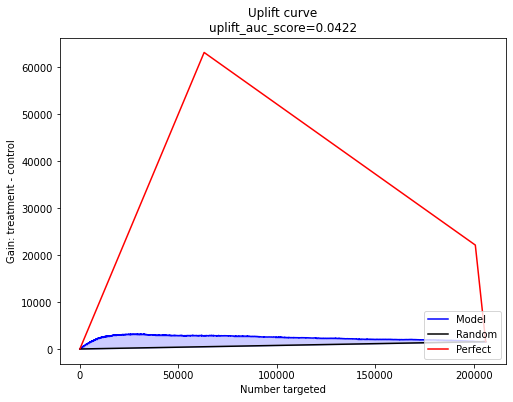

In [22]:
from sklift.viz import plot_uplift_curve

# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_ct, trmnt_val, perfect=True);

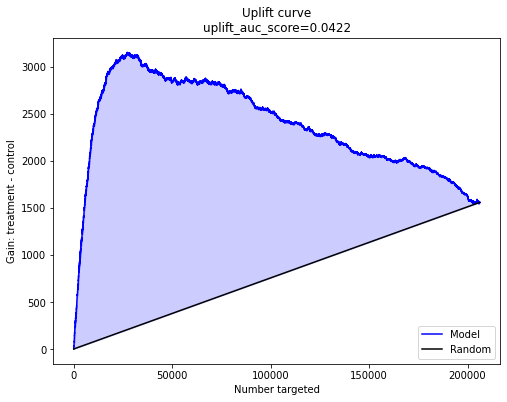

In [23]:
# only real
# perfect=False
plot_uplift_curve(y_val, uplift_ct, trmnt_val, perfect=False);

In [24]:
from sklift.metrics import uplift_auc_score

# AUUQ = area under uplift curve
auuc = uplift_auc_score(y_val, uplift_ct, trmnt_val) 
print(f"Uplift auc score on full data: {auuc:.4f}")

Uplift auc score on full data: 0.0422
